## 🌐 **Google Drive Connection**

In [1]:
# Install and configure Kaggle API
!pip install -q kaggle

from google.colab import files
print("Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)")
files.upload()  # select kaggle.json from your pc, using the API from user->setting in KAGGLE (create new token)

# Configura le credenziali
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Monta Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

# Percorso di destinazione sul Drive
dataset_path = "/content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
!mkdir -p {dataset_path}

# Scarica il dataset direttamente da Kaggle nella cartella scelta
!kaggle competitions download -c an2dl2526c1 -p {dataset_path}

# Decomprimi (opzionale, solo se i file sono .zip)
!unzip -o {dataset_path}/an2dl2526c1.zip -d {dataset_path}

print(f"Dataset scaricato e disponibile in: {dataset_path}")


Carica il file kaggle.json (scaricabile dal tuo profilo Kaggle)


Saving kaggle.json to kaggle.json
Mounted at /content/gdrive
an2dl2526c1.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/an2dl2526c1.zip
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_test.csv  
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train.csv  
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/pirate_pain_train_labels.csv  
  inflating: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset/sample_submission.csv  
Dataset scaricato e disponibile in: /content/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset


## ⚙️ **Libraries Import**

In [2]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models

if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

PyTorch version: 2.8.0+cu126
Device: cuda


## ⏳ **Data Loading**

In [14]:
dataset_path = "/gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset"
os.makedirs(dataset_path, exist_ok=True)

competition = "an2dl2526c1"
# file needed
dataset_files = ["pirate_pain_test.csv", "pirate_pain_train.csv", "pirate_pain_train_labels.csv"]

# Download file if not done yet
for fname in dataset_files:
    dest_path = os.path.join(dataset_path, fname)
    if not os.path.exists(dest_path):
        print(f"📥 Downloading {fname} ...")
        !kaggle competitions download -c {competition} -f {fname} -p {dataset_path}
    else:
        print(f"✅ {fname} already exists. Using cached version.")

print("\nAll files ready in:", dataset_path)


✅ pirate_pain_test.csv already exists. Using cached version.
✅ pirate_pain_train.csv already exists. Using cached version.
✅ pirate_pain_train_labels.csv already exists. Using cached version.

All files ready in: /gdrive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/dataset


In [15]:
df_training = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train.csv"))
df_labels = pd.read_csv(os.path.join(dataset_path, "pirate_pain_train_labels.csv"))

## 🔎 **Data exploration and profiling**

In [ ]:
#data_profile = ProfileReport(df_training, title="Profiling Report")
#data_profile

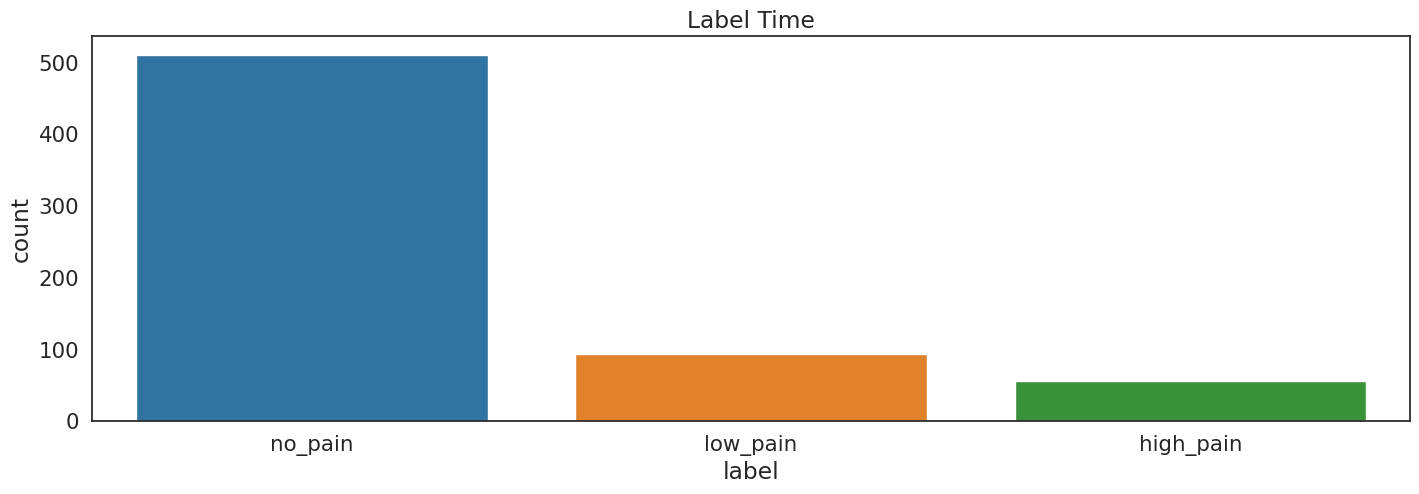

In [16]:
# Visualise the count of time for each label
plt.figure(figsize=(17, 5))
sns.countplot(
    x='label',
    data=df_labels,
    order=df_labels['label'].value_counts().index,
    palette='tab10'
)

# Set the title of the plot
plt.title('Label Time')

# Display the plot
plt.show()

In [17]:
# Count the number of unique subjects
n_subjects = df_training['sample_index'].nunique()
print(f"Number of subjects: {n_subjects}")
sample_per_index = df_training.groupby('sample_index').size()
print(f"Number of timestamps per subjects: {sample_per_index}")

Number of subjects: 661
Number of timestamps per subjects: sample_index
0      160
1      160
2      160
3      160
4      160
      ... 
656    160
657    160
658    160
659    160
660    160
Length: 661, dtype: int64


## 🧹 **Data cleaning**

In [18]:
from scipy.stats.mstats import winsorize
# ============================
# 1. Convert joint columns
# ============================
joint_cols = [col for col in df_training.columns if col.startswith("joint_")]
for col in joint_cols:
    df_training[col] = pd.to_numeric(df_training[col], errors='coerce').astype('float32')

# ============================
# 2. Convert survey values
# ============================
survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']

for col in survey_cols:
    df_training[col] = pd.Categorical(
        df_training[col].astype('int'),
        categories=[0, 1, 2],
        ordered=True
    )

# ============================
# 3. One-Hot Encoding for injury-related categorical variables
# ============================
df_training['is_injured'] = (df_training['n_legs'] != 'two').astype('int8')
df_training['is_injured'] = df_training['is_injured'].astype('category')


# ============================
# 4. Drop useless joint columns (proper comma-separated list)
# ============================

# TODO: TRIES DIFFERENT COMBINATION --> REASON ABOUT THEORY TO UNDERSTAND THE BEST ONE
cols_to_drop = [
    'joint_30',         # constant
    'n_eyes', 'n_hands', 'n_legs'
]

#cols_to_drop = [
    #'joint_30',         # constant

      #   Not Unique-value
    #'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17',
    #'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22',
    #'joint_23', 'joint_24', 'joint_25'

    # Unique-value
    #'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12',
    #'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04',
    #'joint_05', 'joint_06', 'joint_07', 'joint_26', 'joint_27',
    #'joint_28', 'joint_29'
#]

df_training = df_training.drop(columns=[c for c in cols_to_drop if c in df_training.columns])


# ============================
# 5. create a single dataset with the labels associated
# ============================
df = df_training.merge(df_labels, on='sample_index', how='left')
df = df.rename(columns={'label': 'pain_label'})  # rename if needed
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 38 columns):
 #   Column         Non-Null Count   Dtype   
---  ------         --------------   -----   
 0   sample_index   105760 non-null  int64   
 1   time           105760 non-null  int64   
 2   pain_survey_1  105760 non-null  category
 3   pain_survey_2  105760 non-null  category
 4   pain_survey_3  105760 non-null  category
 5   pain_survey_4  105760 non-null  category
 6   joint_00       105760 non-null  float32 
 7   joint_01       105760 non-null  float32 
 8   joint_02       105760 non-null  float32 
 9   joint_03       105760 non-null  float32 
 10  joint_04       105760 non-null  float32 
 11  joint_05       105760 non-null  float32 
 12  joint_06       105760 non-null  float32 
 13  joint_07       105760 non-null  float32 
 14  joint_08       105760 non-null  float32 
 15  joint_09       105760 non-null  float32 
 16  joint_10       105760 non-null  float32 
 17  joint_11  

In [19]:
# Count the number of unique subjects
n_subjects = df_training['sample_index'].nunique()
print(f"Number of subjects: {n_subjects}")
sample_per_index = df_training.groupby('sample_index').size()
print(f"Number of timestamps per subjects: {sample_per_index}")

Number of subjects: 661
Number of timestamps per subjects: sample_index
0      160
1      160
2      160
3      160
4      160
      ... 
656    160
657    160
658    160
659    160
660    160
Length: 661, dtype: int64


# **Split subjects into train / val (subject-wise splitting)**

In [20]:
unique_subjects = df_training['sample_index'].unique()
random.seed(SEED)
random.shuffle(unique_subjects)

N_VAL = int(0.2 * len(unique_subjects))  # 20% for validation
N_TRAIN = len(unique_subjects) - N_VAL

train_subjects = unique_subjects[:N_TRAIN]
val_subjects = unique_subjects[N_TRAIN:]

df_train = df[df['sample_index'].isin(train_subjects)].copy()
df_val = df[df['sample_index'].isin(val_subjects)].copy()

print(f"Training samples: {df_train['sample_index'].nunique()}")
print(f"Validation samples: {df_val['sample_index'].nunique()}")


Training samples: 529
Validation samples: 132


# **Mapping labels to integers**

In [21]:
label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}

df_train['label_enc'] = df_train['pain_label'].map(label_mapping)
df_val['label_enc'] = df_val['pain_label'].map(label_mapping)

# **NORMALIZATION**

In [22]:
# Frequenze delle classi nel training set (dopo label encoding)
train_counts = df_train['label_enc'].value_counts().sort_index().values

# Calcolo pesi inversamente proporzionali alla frequenza
class_weights = 1.0 / torch.tensor(train_counts, dtype=torch.float32)

# Normalizzazione (raccomandata)
class_weights = class_weights / class_weights.sum()

print("Class counts (train):", train_counts)
print("Class weights:", class_weights)

Class counts (train): [65440 12000  7200]
Class weights: tensor([0.0643, 0.3509, 0.5848])


In [23]:
# List of columns to normalize (all continuous features)
feature_cols = [col for col in df_train.columns if col.startswith('joint_')]

# Compute min/max on training set only
mins = df_train[feature_cols].min()
maxs = df_train[feature_cols].max()

# Apply min-max scaling to train/val (and test later)
for col in feature_cols:
    df_train[col] = (df_train[col] - mins[col]) / (maxs[col] - mins[col])
    df_val[col] = (df_val[col] - mins[col]) / (maxs[col] - mins[col])
    # df_test[col] = (df_test[col] - mins[col]) / (maxs[col] - mins[col])  # only if df_test exists


# **Sliding-window sequence creation**

In [24]:
# Define the window size
WINDOW_SIZE = 40

# Define the stride for overlapping windows
STRIDE = 20

In [25]:
def build_windows(df, window=40, stride=20):
    X_windows = []
    y_windows = []
    for sid, group in df.groupby('sample_index'):
        X = group[feature_cols].values.astype('float32')
        y = group['label_enc'].values[0]

        # pad if needed
        padding_len = (window - len(X) % window) % window
        if padding_len > 0:
            X = np.concatenate([X, np.zeros((padding_len, X.shape[1]), dtype='float32')])

        # create windows
        for start in range(0, len(X) - window + 1, stride):
            X_windows.append(X[start:start+window])
            y_windows.append(y)

    return np.array(X_windows), np.array(y_windows)

# Example:
X_train, y_train = build_windows(df_train, WINDOW_SIZE, STRIDE)
X_val, y_val = build_windows(df_val, WINDOW_SIZE, WINDOW_SIZE)

# Print the shapes of the generated datasets and their labels
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val:  ", X_val.shape,   "y_val:  ", y_val.shape)



X_train: (3703, 40, 30) y_train: (3703,)
X_val:   (528, 40, 30) y_val:   (528,)


In [26]:
# ✅ Define input shape for the RNN
input_shape = X_train.shape[1:]   # (window_size, num_features)
num_classes = len(np.unique(y_train))

**Convert to PyTorch datasets**

In [27]:
train_ds = TensorDataset(
    torch.from_numpy(X_train),
    torch.from_numpy(y_train)
)

val_ds = TensorDataset(
    torch.from_numpy(X_val),
    torch.from_numpy(y_val)
)

**Create DataLoaders**

In [28]:
# Define the batch size, which is the number of samples in each batch
BATCH_SIZE = 64

def make_loader(ds, batch_size, shuffle, drop_last):
    cpu_cores = os.cpu_count() or 2
    num_workers = max(2, min(4, cpu_cores))

    return DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
        pin_memory_device="cuda" if torch.cuda.is_available() else "",
        prefetch_factor=4
    )

train_loader = make_loader(train_ds, BATCH_SIZE, True,  False)
val_loader   = make_loader(val_ds,   BATCH_SIZE, False, False)

for xb, yb in train_loader:
    print("Features batch shape:", xb.shape)  # (B, WINDOW_SIZE, num_features)
    print("Labels batch shape:", yb.shape)    # (B,)
    break

Features batch shape: torch.Size([64, 40, 30])
Labels batch shape: torch.Size([64])


## 🛠️ **Model Building**

In [29]:
def recurrent_summary(model, input_size):
    """
    Custom summary function that emulates torchinfo's output while correctly
    counting parameters for RNN/GRU/LSTM layers.

    This function is designed for models whose direct children are
    nn.Linear, nn.RNN, nn.GRU, or nn.LSTM layers.

    Args:
        model (nn.Module): The model to analyze.
        input_size (tuple): Shape of the input tensor (e.g., (seq_len, features)).
    """

    # Dictionary to store output shapes captured by forward hooks
    output_shapes = {}
    # List to track hook handles for later removal
    hooks = []

    def get_hook(name):
        """Factory function to create a forward hook for a specific module."""
        def hook(module, input, output):
            # Handle RNN layer outputs (returns a tuple)
            if isinstance(output, tuple):
                # output[0]: all hidden states with shape (batch, seq_len, hidden*directions)
                shape1 = list(output[0].shape)
                shape1[0] = -1  # Replace batch dimension with -1

                # output[1]: final hidden state h_n (or tuple (h_n, c_n) for LSTM)
                if isinstance(output[1], tuple):  # LSTM case: (h_n, c_n)
                    shape2 = list(output[1][0].shape)  # Extract h_n only
                else:  # RNN/GRU case: h_n only
                    shape2 = list(output[1].shape)

                # Replace batch dimension (middle position) with -1
                shape2[1] = -1

                output_shapes[name] = f"[{shape1}, {shape2}]"

            # Handle standard layer outputs (e.g., Linear)
            else:
                shape = list(output.shape)
                shape[0] = -1  # Replace batch dimension with -1
                output_shapes[name] = f"{shape}"
        return hook

    # 1. Determine the device where model parameters reside
    try:
        device = next(model.parameters()).device
    except StopIteration:
        device = torch.device("cpu")  # Fallback for models without parameters

    # 2. Create a dummy input tensor with batch_size=1
    dummy_input = torch.randn(1, *input_size).to(device)

    # 3. Register forward hooks on target layers
    # Iterate through direct children of the model (e.g., self.rnn, self.classifier)
    for name, module in model.named_children():
        if isinstance(module, (nn.Linear, nn.RNN, nn.GRU, nn.LSTM)):
            # Register the hook and store its handle for cleanup
            hook_handle = module.register_forward_hook(get_hook(name))
            hooks.append(hook_handle)

    # 4. Execute a dummy forward pass in evaluation mode
    model.eval()
    with torch.no_grad():
        try:
            model(dummy_input)
        except Exception as e:
            print(f"Error during dummy forward pass: {e}")
            # Clean up hooks even if an error occurs
            for h in hooks:
                h.remove()
            return

    # 5. Remove all registered hooks
    for h in hooks:
        h.remove()

    # --- 6. Print the summary table ---

    print("-" * 79)
    # Column headers
    print(f"{'Layer (type)':<25} {'Output Shape':<28} {'Param #':<18}")
    print("=" * 79)

    total_params = 0
    total_trainable_params = 0

    # Iterate through modules again to collect and display parameter information
    for name, module in model.named_children():
        if name in output_shapes:
            # Count total and trainable parameters for this module
            module_params = sum(p.numel() for p in module.parameters())
            trainable_params = sum(p.numel() for p in module.parameters() if p.requires_grad)

            total_params += module_params
            total_trainable_params += trainable_params

            # Format strings for display
            layer_name = f"{name} ({type(module).__name__})"
            output_shape_str = str(output_shapes[name])
            params_str = f"{trainable_params:,}"

            print(f"{layer_name:<25} {output_shape_str:<28} {params_str:<15}")

    print("=" * 79)
    print(f"Total params: {total_params:,}")
    print(f"Trainable params: {total_trainable_params:,}")
    print(f"Non-trainable params: {total_params - total_trainable_params:,}")
    print("-" * 79)

In [30]:
class RecurrentClassifier(nn.Module):
    def __init__(
            self,
            input_size,
            hidden_size,
            num_layers,
            num_classes,
            rnn_type='GRU',
            bidirectional=False,
            dropout_rate=0.2
        ):
        super().__init__()

        self.rnn_type = rnn_type
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        rnn_map = {
            'RNN': nn.RNN,
            'LSTM': nn.LSTM,
            'GRU': nn.GRU
        }

        rnn_module = rnn_map[rnn_type]

        dropout_val = dropout_rate if num_layers > 1 else 0.0

        self.rnn = rnn_module(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout_val
        )

        if bidirectional:
            classifier_input = hidden_size * 2
        else:
            classifier_input = hidden_size
        # 🔥 Nuova testa MLP
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        rnn_out, hidden = self.rnn(x)

        if self.rnn_type == 'LSTM':
            hidden = hidden[0]  # h_n only

        if self.bidirectional:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size)
            hidden_to_classify = torch.cat([hidden[-1, 0], hidden[-1, 1]], dim=1)
        else:
            hidden_to_classify = hidden[-1]

        return self.classifier(hidden_to_classify)


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


**Network and Training Hyperparameters**

## 🧠 **Model Training**

In [32]:
# Initialize best model tracking variables
best_model = None
best_performance = float('-inf')

In [33]:
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    """
    Perform one complete training epoch through the entire training dataset.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): Lambda for L1 regularization
        l2_lambda (float): Lambda for L2 regularization

    Returns:
        tuple: (average_loss, f1 score) - Training loss and f1 score for this epoch
    """
    model.train()  # Set model to training mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Iterate through training batches
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        inputs, targets = inputs.to(device), targets.to(device)

        # Clear gradients from previous step
        optimizer.zero_grad(set_to_none=True)

        # Forward pass with mixed precision (if CUDA available)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)

            # Add L1 and L2 regularization
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            l2_norm = sum(p.pow(2).sum() for p in model.parameters())
            loss = loss + l1_lambda * l1_norm + l2_lambda * l2_norm


        # Backward pass with gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Accumulate metrics
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_f1

In [34]:
def validate_one_epoch(model, val_loader, criterion, device):
    """
    Perform one complete validation epoch through the entire validation dataset.

    Args:
        model (nn.Module): The neural network model to evaluate (must be in eval mode)
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        criterion (nn.Module): Loss function used to calculate validation loss
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)

    Returns:
        tuple: (average_loss, accuracy) - Validation loss and accuracy for this epoch

    Note:
        This function automatically sets the model to evaluation mode and disables
        gradient computation for efficiency during validation.
    """
    model.eval()  # Set model to evaluation mode

    running_loss = 0.0
    all_predictions = []
    all_targets = []

    # Disable gradient computation for validation
    with torch.no_grad():
        for inputs, targets in val_loader:
            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass with mixed precision (if CUDA available)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs)
                loss = criterion(logits, targets)

            # Accumulate metrics
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    # Calculate epoch metrics
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_accuracy = f1_score(
        np.concatenate(all_targets),
        np.concatenate(all_predictions),
        average='weighted'
    )

    return epoch_loss, epoch_accuracy

In [35]:
def log_metrics_to_tensorboard(writer, epoch, train_loss, train_f1, val_loss, val_f1, model):
    """
    Log training metrics and model parameters to TensorBoard for visualization.

    Args:
        writer (SummaryWriter): TensorBoard SummaryWriter object for logging
        epoch (int): Current epoch number (used as x-axis in TensorBoard plots)
        train_loss (float): Training loss for this epoch
        train_f1 (float): Training f1 score for this epoch
        val_loss (float): Validation loss for this epoch
        val_f1 (float): Validation f1 score for this epoch
        model (nn.Module): The neural network model (for logging weights/gradients)

    Note:
        This function logs scalar metrics (loss/f1 score) and histograms of model
        parameters and gradients, which helps monitor training progress and detect
        issues like vanishing/exploding gradients.
    """
    # Log scalar metrics
    writer.add_scalar('Loss/Training', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalar('F1/Training', train_f1, epoch)
    writer.add_scalar('F1/Validation', val_f1, epoch)

    # Log model parameters and gradients
    for name, param in model.named_parameters():
        if param.requires_grad:
            # Check if the tensor is not empty before adding a histogram
            if param.numel() > 0:
                writer.add_histogram(f'{name}/weights', param.data, epoch)
            if param.grad is not None:
                # Check if the gradient tensor is not empty before adding a histogram
                if param.grad.numel() > 0:
                    if param.grad is not None and torch.isfinite(param.grad).all():
                        writer.add_histogram(f'{name}/gradients', param.grad.data, epoch)

In [36]:
def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10, experiment_name=""):
    """
    Train the neural network model on the training data and validate on the validation data.

    Args:
        model (nn.Module): The neural network model to train
        train_loader (DataLoader): PyTorch DataLoader containing training data batches
        val_loader (DataLoader): PyTorch DataLoader containing validation data batches
        epochs (int): Number of training epochs
        criterion (nn.Module): Loss function (e.g., CrossEntropyLoss, MSELoss)
        optimizer (torch.optim): Optimization algorithm (e.g., Adam, SGD)
        scaler (GradScaler): PyTorch's gradient scaler for mixed precision training
        device (torch.device): Computing device ('cuda' for GPU, 'cpu' for CPU)
        l1_lambda (float): L1 regularization coefficient (default: 0)
        l2_lambda (float): L2 regularization coefficient (default: 0)
        patience (int): Number of epochs to wait for improvement before early stopping (default: 0)
        evaluation_metric (str): Metric to monitor for early stopping (default: "val_f1")
        mode (str): 'max' for maximizing the metric, 'min' for minimizing (default: 'max')
        restore_best_weights (bool): Whether to restore model weights from best epoch (default: True)
        writer (SummaryWriter, optional): TensorBoard SummaryWriter object for logging (default: None)
        verbose (int, optional): Frequency of printing training progress (default: 10)
        experiment_name (str, optional): Experiment name for saving models (default: "")

    Returns:
        tuple: (model, training_history) - Trained model and metrics history
    """

    # Initialize metrics tracking
    training_history = {
        'train_loss': [], 'val_loss': [],
        'train_f1': [], 'val_f1': []
    }

    # Configure early stopping if patience is set
    if patience > 0:
        patience_counter = 0
        best_metric = float('-inf') if mode == 'max' else float('inf')
        best_epoch = 0

    print(f"Training {epochs} epochs...")

    # Main training loop: iterate through epochs
    for epoch in range(1, epochs + 1):

        # Forward pass through training data, compute gradients, update weights
        train_loss, train_f1 = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda
        )

        # Evaluate model on validation data without updating weights
        val_loss, val_f1 = validate_one_epoch(
            model, val_loader, criterion, device
        )

        # Store metrics for plotting and analysis
        training_history['train_loss'].append(train_loss)
        training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1)
        training_history['val_f1'].append(val_f1)

        # Write metrics to TensorBoard for visualization
        if writer is not None:
            log_metrics_to_tensorboard(
                writer, epoch, train_loss, train_f1, val_loss, val_f1, model
            )

        # Print progress every N epochs or on first epoch
        if verbose > 0:
            if epoch % verbose == 0 or epoch == 1:
                print(f"Epoch {epoch:3d}/{epochs} | "
                    f"Train: Loss={train_loss:.4f}, F1 Score={train_f1:.4f} | "
                    f"Val: Loss={val_loss:.4f}, F1 Score={val_f1:.4f}")

        # Early stopping logic: monitor metric and save best model
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)

            if is_improvement:
                best_metric = current_metric
                best_epoch = epoch
                torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after {epoch} epochs.")
                    break

    # Restore best model weights if early stopping was used
    if restore_best_weights and patience > 0:
        model.load_state_dict(torch.load("models/"+experiment_name+'_model.pt'))
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")

    # Save final model if no early stopping
    if patience == 0:
        torch.save(model.state_dict(), "models/"+experiment_name+'_model.pt')

    # Close TensorBoard writer
    if writer is not None:
        writer.close()

    return model, training_history

# **TRAINING HYPERPARAMETERS**

In [37]:
# ----------------------------
# TRAINING HYPERPARAMETERS
# ----------------------------
LEARNING_RATE = 1e-3
EPOCHS = 500
PATIENCE = 50

HIDDEN_LAYERS = 2
HIDDEN_SIZE = 128
DROPOUT_RATE = 0.3
L1_LAMBDA = 0.010
L2_LAMBDA = 0.000


In [38]:
# ----------------------------
# MODEL
# ----------------------------
# Create model and display architecture with parameter count
rnn_model = RecurrentClassifier(
    input_size=input_shape[-1], # Pass the number of features
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False, #True #False
    rnn_type='GRU'  # 'RNN', 'LSTM', or 'GRU'
    ).to(device)
recurrent_summary(rnn_model, input_size=input_shape)

# Set up TensorBoard logging and save model architecture
experiment_name = "rnn"
writer = SummaryWriter("./"+logs_dir+"/"+experiment_name)
x = torch.randn(1, input_shape[0], input_shape[1]).to(device)
writer.add_graph(rnn_model, x)


# ----------------------------
# OPTIMIZER & MIXED PRECISION
# ----------------------------

# Define optimizer with L2 regularization
optimizer = torch.optim.AdamW(rnn_model.parameters(), lr=LEARNING_RATE, weight_decay=L2_LAMBDA)
# optimizer = torch.optim.Adam(rnn_model.parameters(), lr=LEARNING_RATE)

# Enable mixed precision training for GPU acceleration
scaler = torch.amp.GradScaler(enabled=(device.type == 'cuda'))
criterion = nn.CrossEntropyLoss()

-------------------------------------------------------------------------------
Layer (type)              Output Shape                 Param #           
rnn (GRU)                 [[-1, 40, 128], [2, -1, 128]] 160,512        
Total params: 160,512
Trainable params: 160,512
Non-trainable params: 0
-------------------------------------------------------------------------------


In [39]:
%%time
# Train model and track training history
rnn_model, training_history = fit(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    writer=writer,
    verbose=10,
    experiment_name="rnn",
    patience=PATIENCE
    )

# Update best model if current performance is superior
if training_history['val_f1'][-1] > best_performance:
    best_model = rnn_model
    best_performance = training_history['val_f1'][-1]

Training 500 epochs...
Epoch   1/500 | Train: Loss=0.7353, F1 Score=0.6725 | Val: Loss=0.6764, F1 Score=0.6737
Epoch  10/500 | Train: Loss=0.3051, F1 Score=0.8838 | Val: Loss=0.3821, F1 Score=0.8904
Epoch  20/500 | Train: Loss=0.2150, F1 Score=0.9211 | Val: Loss=0.4016, F1 Score=0.8569
Epoch  30/500 | Train: Loss=0.1172, F1 Score=0.9566 | Val: Loss=0.4761, F1 Score=0.8758
Epoch  40/500 | Train: Loss=0.0656, F1 Score=0.9766 | Val: Loss=0.3955, F1 Score=0.9223
Epoch  50/500 | Train: Loss=0.0665, F1 Score=0.9756 | Val: Loss=0.5008, F1 Score=0.8979
Epoch  60/500 | Train: Loss=0.0690, F1 Score=0.9753 | Val: Loss=0.4202, F1 Score=0.9174
Epoch  70/500 | Train: Loss=0.0718, F1 Score=0.9760 | Val: Loss=0.5408, F1 Score=0.8993
Epoch  80/500 | Train: Loss=0.0978, F1 Score=0.9661 | Val: Loss=0.6999, F1 Score=0.8765
Epoch  90/500 | Train: Loss=0.0360, F1 Score=0.9862 | Val: Loss=0.6129, F1 Score=0.9005
Epoch 100/500 | Train: Loss=0.0241, F1 Score=0.9916 | Val: Loss=0.5358, F1 Score=0.9157
Epoch 110

In [40]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import numpy as np

def evaluate_final_model(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_targets.append(yb.cpu().numpy())

    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)

    return all_targets, all_preds

# -----------------------------------------
# ESECUZIONE
# -----------------------------------------
targets, preds = evaluate_final_model(rnn_model, val_loader, device)

# F1 per classe
class_f1 = f1_score(targets, preds, average=None)

# Mappa classi -> nome
id_to_label = {0: "no_pain", 1: "low_pain", 2: "high_pain"}

print("\n📌 F1 per classe (modello finale):")
for idx, f1 in enumerate(class_f1):
    print(f"  {id_to_label[idx]}: {f1:.4f}")

# Report completo opzionale
print("\n📌 Classification report:")
print(classification_report(targets, preds, target_names=[id_to_label[i] for i in range(3)]))

# Confusion matrix opzionale
print("\n📌 Confusion matrix:")
print(confusion_matrix(targets, preds))


📌 F1 per classe (modello finale):
  no_pain: 0.9651
  low_pain: 0.8551
  high_pain: 0.7356

📌 Classification report:
              precision    recall  f1-score   support

     no_pain       0.95      0.98      0.97       408
    low_pain       0.95      0.78      0.86        76
   high_pain       0.74      0.73      0.74        44

    accuracy                           0.93       528
   macro avg       0.88      0.83      0.85       528
weighted avg       0.93      0.93      0.93       528


📌 Confusion matrix:
[[401   2   5]
 [ 11  59   6]
 [ 11   1  32]]


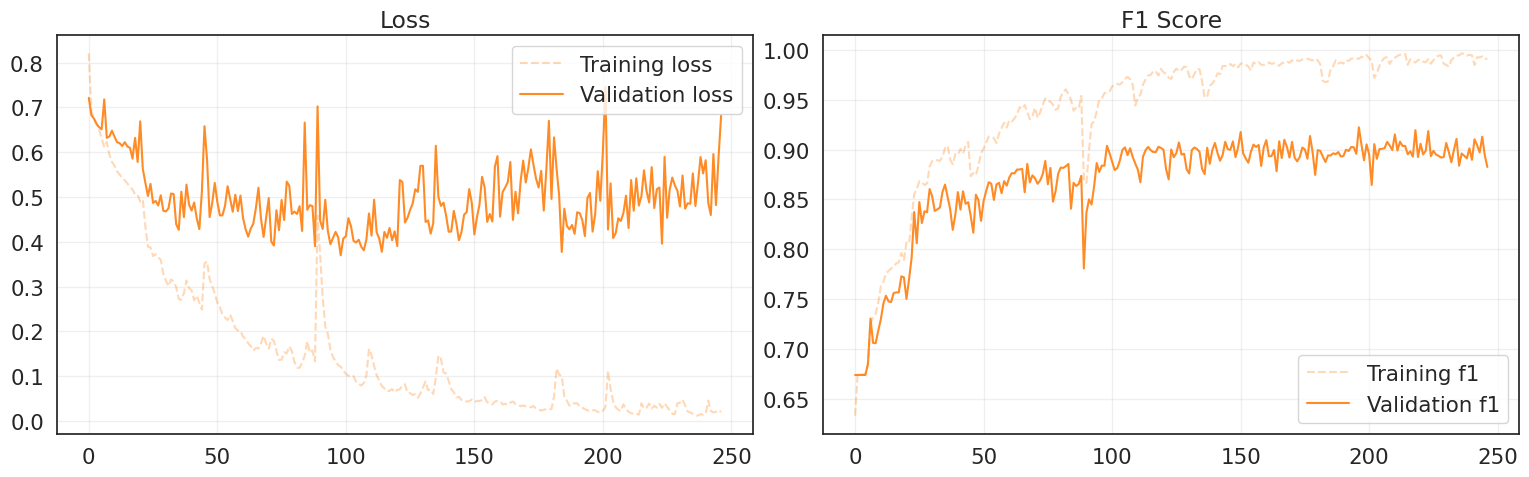

In [ ]:
# @title Plot Hitory
# Create a figure with two side-by-side subplots (two columns)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 5))

# Plot of training and validation loss on the first axis
ax1.plot(training_history['train_loss'], label='Training loss', alpha=0.3, color='#ff7f0e', linestyle='--')
ax1.plot(training_history['val_loss'], label='Validation loss', alpha=0.9, color='#ff7f0e')
ax1.set_title('Loss')
ax1.legend()
ax1.grid(alpha=0.3)

# Plot of training and validation accuracy on the second axis
ax2.plot(training_history['train_f1'], label='Training f1', alpha=0.3, color='#ff7f0e', linestyle='--')
ax2.plot(training_history['val_f1'], label='Validation f1', alpha=0.9, color='#ff7f0e')
ax2.set_title('F1 Score')
ax2.legend()
ax2.grid(alpha=0.3)

# Adjust the layout and display the plot
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

Accuracy over the validation set: 0.9318
Precision over the validation set: 0.9315
Recall over the validation set: 0.9318
F1 score over the validation set: 0.9301


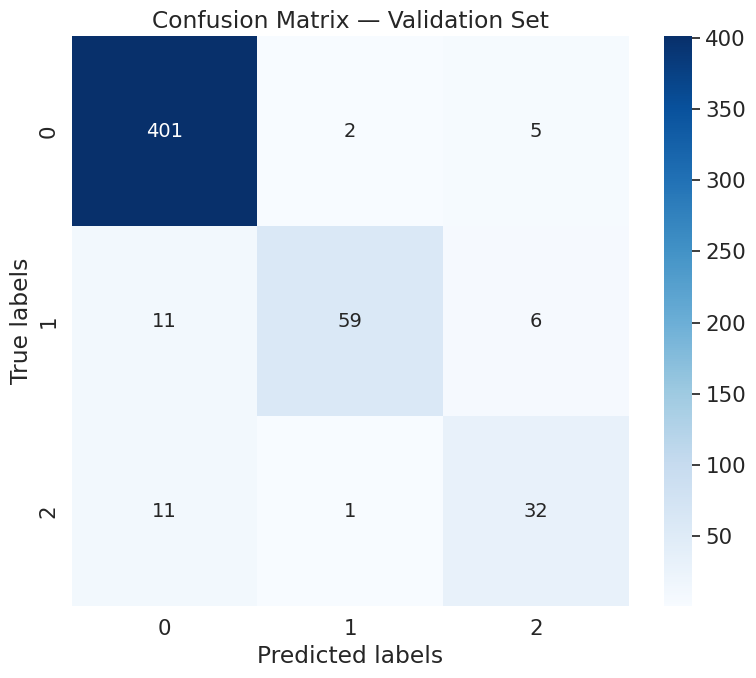

In [ ]:
# @title Plot Confusion Matrix
# Collect predictions and ground truth labels
val_preds, val_targets = [], []
with torch.no_grad():  # Disable gradient computation for inference
    for xb, yb in val_loader:
        xb = xb.to(device)

        # Forward pass: get model predictions
        logits = rnn_model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()

        # Store batch results
        val_preds.append(preds)
        val_targets.append(yb.numpy())

# Combine all batches into single arrays
val_preds = np.concatenate(val_preds)
val_targets = np.concatenate(val_targets)

# Calculate overall validation metrics
val_acc = accuracy_score(val_targets, val_preds)
val_prec = precision_score(val_targets, val_preds, average='weighted')
val_rec = recall_score(val_targets, val_preds, average='weighted')
val_f1 = f1_score(val_targets, val_preds, average='weighted')
print(f"Accuracy over the validation set: {val_acc:.4f}")
print(f"Precision over the validation set: {val_prec:.4f}")
print(f"Recall over the validation set: {val_rec:.4f}")
print(f"F1 score over the validation set: {val_f1:.4f}")

# Generate confusion matrix for detailed error analysis
cm = confusion_matrix(val_targets, val_preds)

# Create numeric labels for heatmap annotation
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Visualise confusion matrix
plt.figure(figsize=(8, 7))
sns.heatmap(cm, annot=labels, fmt='',
            cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix — Validation Set')
plt.tight_layout()
plt.show()

In [ ]:
# Copy TensorBoard logs to accessible location for Colab
!rsync -a $current_dir"/"$logs_dir/ "/content/"$logs_dir/

# Launch TensorBoard interface
%tensorboard --logdir "/content/"$logs_dir

Output streaming troncato alle ultime 5000 righe.
rsync: [sender] read errors mapping "/sys/kernel/slab/kmalloc-cg-32/store_user": No data available (61)
rsync: [sender] read errors mapping "/sys/kernel/slab/kmalloc-cg-32/total_objects": No data available (61)
rsync: [sender] read errors mapping "/sys/kernel/slab/kmalloc-cg-32/trace": No data available (61)
rsync: [sender] read errors mapping "/sys/kernel/slab/kmalloc-cg-32/usersize": No data available (61)
ERROR: sys/kernel/slab/kmalloc-cg-2k/shrink failed verification -- update discarded.
ERROR: sys/kernel/slab/kmalloc-cg-2k/slab_size failed verification -- update discarded.
ERROR: sys/kernel/slab/kmalloc-cg-2k/slabs failed verification -- update discarded.
ERROR: sys/kernel/slab/kmalloc-cg-2k/slabs_cpu_partial failed verification -- update discarded.
ERROR: sys/kernel/slab/kmalloc-cg-2k/store_user failed verification -- update discarded.
ERROR: sys/kernel/slab/kmalloc-cg-2k/total_objects failed verification -- update discarded.
ERRO

Launching TensorBoard...

KeyboardInterrupt: 

# **K-Shuffle-Split Cross Validation**

In [48]:
# Cross-validation
K = 5                    # Number of splits (5 and 10 are considered good values)
N_VAL_USERS = round(0.2 * (len(df['sample_index'].unique())))
N_TEST_USERS = 0
label_mapping = {'no_pain': 0, 'low_pain': 1, 'high_pain': 2}
df['label_enc'] = df['pain_label'].map(label_mapping).astype(int)


# Training
EPOCHS = 500             # Maximum epochs (increase to improve performance)
PATIENCE = 50            # Early stopping patience (increase to improve performance)
VERBOSE = 10             # Print frequency

# Optimisation
LEARNING_RATE = 1e-4     # Learning rate
BATCH_SIZE = 64         # Batch size
WINDOW_SIZE = 40        # Input window size
STRIDE = 10              # Input stride

# Architecture
HIDDEN_LAYERS = 2        # Hidden layers
HIDDEN_SIZE = 128        # Neurons per layer
RNN_TYPE = 'LSTM'         # Type of RNN architecture
BIDIRECTIONAL = True    # Bidirectional RNN

# Regularisation
DROPOUT_RATE = 0.1       # Dropout probability
L1_LAMBDA = 0.000            # L1 penalty
L2_LAMBDA = 0            # L2 penalty

# Training utilities
criterion = nn.CrossEntropyLoss()



In [49]:
def k_shuffle_split_cross_validation_pain(
        df, feature_cols, epochs, criterion, device,
        k, n_val_users, n_test_users, batch_size,
        hidden_layers, hidden_size, learning_rate, dropout_rate,
        window_size, stride, rnn_type, bidirectional,
        l1_lambda=0, l2_lambda=0, patience=0,
        evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, writer=None, verbose=10,
        seed=42, experiment_name="pain_rnn"):

    fold_losses = {}
    fold_metrics = {}
    best_scores = {}

    # ---- number of features after preprocessing ----
    #in_features = df_training.shape[1]
    #in_features = df.drop(columns=['sample_index', 'pain_label']).shape[1]
    in_features = len(feature_cols)
    num_classes = df['label_enc'].nunique()


    # ---- initialise model once, reset state every split ----
    model = RecurrentClassifier(
        input_size=in_features,
        hidden_size=hidden_size,
        num_layers=hidden_layers,
        num_classes=num_classes,
        dropout_rate=dropout_rate,
        bidirectional=bidirectional,
        rnn_type=rnn_type
    ).to(device)

    # Store initial weights to reset model for each split
    initial_state = copy.deepcopy(model.state_dict())

    # ------------------ K SPLITS ------------------
    # Iterate through K random splits
    for split_idx in range(k):

        if verbose:
            print(f"\n=== Split {split_idx+1}/{k} ===")

        unique_users = df['sample_index'].unique()
        random.seed(seed + split_idx)
        random.shuffle(unique_users)

        # Calculate the number of users for the training set
        n_train_users = len(unique_users) - n_val_users - n_test_users

        # Split the shuffled user IDs into training, validation, and test sets
        train_users = unique_users[:n_train_users]
        val_users   = unique_users[n_train_users:n_train_users+n_val_users]
        test_users  = unique_users[n_train_users+n_val_users:]

        df_train = df[df['sample_index'].isin(train_users)].copy()
        df_val   = df[df['sample_index'].isin(val_users)].copy()
        df_test  = df[df['sample_index'].isin(test_users)].copy()

        # ------------------ Normalisation ------------------
         # ---- Normalization (only on features) ----
        train_max = df_train[feature_cols].max()
        train_min = df_train[feature_cols].min()
        for d in (df_train, df_val, df_test):
            d[feature_cols] = (d[feature_cols] - train_min) / (train_max - train_min + 1e-8)

        # ---- Build sequences ----
        X_train, y_train = build_windows(df_train[['sample_index'] + feature_cols + ['label_enc']], window_size, stride)
        X_val, y_val     = build_windows(df_val[['sample_index'] + feature_cols + ['label_enc']], window_size, stride)
        X_test, y_test   = build_windows(df_test[['sample_index'] + feature_cols + ['label_enc']], window_size, stride)

        # ------------------ Loaders ------------------
        train_ds = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
        val_ds   = TensorDataset(torch.from_numpy(X_val).float(),   torch.from_numpy(y_val).long())
        test_ds  = TensorDataset(torch.from_numpy(X_test).float(),  torch.from_numpy(y_test).long())

        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
        test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

        # ---- Reset model weights ----
        model.load_state_dict(initial_state)

        # ---- Optimizer ----
        optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=l2_lambda)

        scaler = torch.amp.GradScaler(enabled=(device.type=='cuda'))

        # Create directory for model checkpoints
        os.makedirs(f"models/{experiment_name}", exist_ok=True)

        # ---- Fit one split ----
        model, history = fit(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            criterion=criterion,
            optimizer=optimizer,
            scaler=scaler,
            device=device,
            writer=writer,
            patience=patience,
            verbose=verbose,
            l1_lambda=l1_lambda,
            evaluation_metric=evaluation_metric,
            mode=mode,
            restore_best_weights=restore_best_weights,
            experiment_name=f"{experiment_name}/split_{split_idx}"
        )

        # ---- Store results ----
        fold_losses[f"split_{split_idx}"] = history['val_loss']
        fold_metrics[f"split_{split_idx}"] = history['val_f1']
        best_scores[f"split_{split_idx}"] = max(history['val_f1'])

    # Compute mean and standard deviation of best scores across splits
    best_scores["mean"] = np.mean([best_scores[k] for k in best_scores if k.startswith("split_")])
    best_scores["std"]  = np.std([best_scores[k] for k in best_scores if k.startswith("split_")])

    if verbose > 0:
        print(f"Best score: {best_scores['mean']:.4f}±{best_scores['std']:.4f}")

    #print(f"\nFinal Result: F1 = {best_scores['mean']:.4f} ± {best_scores['std']:.4f}")

    return fold_losses, fold_metrics, best_scores


In [ ]:
losses, metrics, best_scores = k_shuffle_split_cross_validation_pain(
    df=df,
    feature_cols=feature_cols,
    epochs=EPOCHS,
    criterion=criterion,
    device=device,
    k=K,
    batch_size=BATCH_SIZE,
    hidden_layers=HIDDEN_LAYERS,
    hidden_size=HIDDEN_SIZE,
    learning_rate=LEARNING_RATE,
    dropout_rate=DROPOUT_RATE,
    l1_lambda=L1_LAMBDA,
    l2_lambda=L2_LAMBDA,
    verbose=VERBOSE,
    patience=PATIENCE,
    seed=SEED,
    experiment_name="pain_gru_cv",
    n_val_users=N_VAL_USERS,
    n_test_users=N_TEST_USERS,
    window_size=WINDOW_SIZE,
    stride=STRIDE,
    rnn_type=RNN_TYPE,
    bidirectional=BIDIRECTIONAL
)


=== Split 1/5 ===
Training 500 epochs...
Epoch   1/500 | Train: Loss=0.9215, F1 Score=0.6741 | Val: Loss=0.7037, F1 Score=0.6737
Epoch  10/500 | Train: Loss=0.5793, F1 Score=0.7413 | Val: Loss=0.6139, F1 Score=0.7183
Epoch  20/500 | Train: Loss=0.5287, F1 Score=0.7942 | Val: Loss=0.6020, F1 Score=0.7230
Epoch  30/500 | Train: Loss=0.4890, F1 Score=0.8073 | Val: Loss=0.5825, F1 Score=0.7550
Epoch  40/500 | Train: Loss=0.3562, F1 Score=0.8733 | Val: Loss=0.5194, F1 Score=0.8370
Epoch  50/500 | Train: Loss=0.2882, F1 Score=0.8977 | Val: Loss=0.5014, F1 Score=0.8446
Epoch  60/500 | Train: Loss=0.2533, F1 Score=0.9142 | Val: Loss=0.4997, F1 Score=0.8496
Epoch  70/500 | Train: Loss=0.2270, F1 Score=0.9219 | Val: Loss=0.4445, F1 Score=0.8689
Epoch  80/500 | Train: Loss=0.2215, F1 Score=0.9297 | Val: Loss=0.4193, F1 Score=0.8752
Epoch  90/500 | Train: Loss=0.2012, F1 Score=0.9364 | Val: Loss=0.4365, F1 Score=0.8709
Epoch 100/500 | Train: Loss=0.1809, F1 Score=0.9380 | Val: Loss=0.4604, F1 Sco

# **COMMENTS ON K FOLD**

1.   Cross validation underfits a little bit with respect normal validation
2.   It lacks the model saving procedure
3. It lacks the final training on train+val sets.



# **SAVE THE MODEL !!!!!!!!!!!!!!!!!!!!**

In [ ]:
import torch
import os

# Crea una cartella locale in /content
save_dir = "/content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models"
os.makedirs(save_dir, exist_ok=True)

# Nome del file
MODEL_PATH = os.path.join(save_dir, "best_model.pth")

# Salva solo i pesi
torch.save(best_model.state_dict(), MODEL_PATH)

print(f"✅ Modello salvato localmente in: {MODEL_PATH}")
!ls -lh "$save_dir"

✅ Modello salvato localmente in: /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/best_model.pth
total 700K
-rw-r--r-- 1 root root 697K Nov 14 09:12 best_model.pth


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **KAGGLE INFERENCE**

In [ ]:
# ============================
# 1. Load Test Data
# ============================
df_test = pd.read_csv(os.path.join(dataset_path, "pirate_pain_test.csv"))

# ============================
# 2. Apply the same preprocessing
# ============================

# Convert joint columns
for col in joint_cols:
    df_test[col] = pd.to_numeric(df_test[col], errors='coerce').astype('float32')

# ============================
# 2. Convert survey values
# ============================
survey_cols = ['pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4']
for col in survey_cols:
    df_test[col] = pd.Categorical(
        df_test[col].astype('int'),
        categories=[0, 1, 2],
        ordered=True
    )

# ============================
# 3. One-Hot Encoding for injury-related categorical variables
# ============================
df_test['is_injured'] = (df_test['n_legs'] != 'two').astype('int8')
df_test['is_injured'] = df_test['is_injured'].astype('category')


# Ensure same columns as training (some dummy columns may be missing)
for c in [c for c in df_training.columns if c not in df_test.columns]:
    df_test[c] = 0
df_test = df_test[df_training.columns]  # align column order

# Normalize using train min/max
for col in feature_cols:
    df_test[col] = (df_test[col] - mins[col]) / (maxs[col] - mins[col])

# Drop any NaNs that may appear after normalization
df_test = df_test.fillna(0.0)


In [ ]:
# Build sliding windows for test set (no labels)
def build_windows_test(df, window=40, stride=20):
    X_windows = []
    indices = []  # keep sample_index to know who is who
    for sid, group in df.groupby('sample_index'):
        X = group[feature_cols].values.astype('float32')

        padding_len = (window - len(X) % window) % window
        if padding_len > 0:
            X = np.concatenate([X, np.zeros((padding_len, X.shape[1]), dtype='float32')])

        for start in range(0, len(X) - window + 1, stride):
            X_windows.append(X[start:start+window])
            indices.append(sid)

    return np.array(X_windows), np.array(indices)

X_test, test_indices = build_windows_test(df_test, WINDOW_SIZE, STRIDE)
print("X_test:", X_test.shape)


X_test: (9268, 40, 30)


In [ ]:
# Recreate model and load weights
best_model_path = "/content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/models/best_model.pth"
model_for_inference = RecurrentClassifier(
    input_size=input_shape[-1],
    hidden_size=HIDDEN_SIZE,
    num_layers=HIDDEN_LAYERS,
    num_classes=num_classes,
    dropout_rate=DROPOUT_RATE,
    bidirectional=False,
    rnn_type='GRU'
).to(device)

model_for_inference.load_state_dict(torch.load(best_model_path, map_location=device))
model_for_inference.eval()
print("✅ Model loaded for inference.")


✅ Model loaded for inference.


In [ ]:
# Convert test windows to TensorLoader
test_ds = TensorDataset(torch.from_numpy(X_test))
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

# Collect predictions
all_preds = []

with torch.no_grad():
    for (xb,) in test_loader:
        xb = xb.to(device)
        logits = model_for_inference(xb)
        preds = logits.argmax(dim=1)
        all_preds.append(preds.cpu().numpy())

all_preds = np.concatenate(all_preds)


In [ ]:
# Combine window predictions per subject
pred_df = pd.DataFrame({'sample_index': test_indices, 'pred': all_preds})

# Aggregate by majority vote
final_preds = (
    pred_df.groupby('sample_index')['pred']
    .agg(lambda x: np.bincount(x).argmax())  # most frequent label
    .reset_index()
)

# Map back to label names
inv_label_map = {v: k for k, v in label_mapping.items()}
final_preds['label'] = final_preds['pred'].map(inv_label_map)

print(final_preds.head())


   sample_index  pred    label
0             0     0  no_pain
1             1     0  no_pain
2             2     0  no_pain
3             3     0  no_pain
4             4     0  no_pain


In [ ]:
# Sort by sample_index just in case
final_preds = final_preds.sort_values(by='sample_index')

# Keep only required columns
submission = final_preds[['sample_index', 'label']]

# Save in Kaggle submission format
# submission_path = "/kaggle/working/submission.csv"  # for Kaggle
# Or to your Drive:
submission_path = "/content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/submission.csv"

submission.to_csv(submission_path, index=False)
print(f"✅ Submission file saved at: {submission_path}")
print(submission.head())


✅ Submission file saved at: /content/drive/MyDrive/Artificial_Neural_Networks/Timeseries_Classification_Challenge/submission.csv
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain
